In [1]:
import ipopt
import numpy as np
import time
import operator as op
from functools import reduce
import matplotlib.pyplot as plt
from cyipopt import minimize_ipopt
from jax import jit, grad, jacfwd, jacrev


/home/jlmao/.local/lib/python3.10/site-packages/ipopt/__init__.py:13: FutureWarning: The module has been renamed to 'cyipopt' from 'ipopt'. Please import using 'import cyipopt' and remove all uses of 'import ipopt' in your code as this will be deprecated in a future release.
  warnings.warn(msg, FutureWarning)


In [2]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

class bernObj(object):
    def __init__(self, sfc, polyOrder, maxVel, maxAccel):
        self.sfc = sfc
        self.polyOrder = polyOrder
        self.numCoeff = polyOrder+1
        self.velDeriv = self.matrixDerivative(1)
        self.accDeriv = self.matrixDerivative(2)
        self.maxVel = maxVel
        self.maxAccel = maxAccel
        self.velConst = polyOrder
        #Precomputed 
        self.accConst = polyOrder*(polyOrder-1)
        #Start of the time index
        self.timeIndex = len(sfc)*(polyOrder+1)
        #Hessian matrix
        self.H = np.zeros((len(sfc)*(polyOrder+2),len(sfc)*(polyOrder+2)))
        self.H[len(sfc)*(polyOrder+1):len(sfc)*(polyOrder+2),len(sfc)*(polyOrder+1):len(sfc)*(polyOrder+2)] = 2*np.eye(len(sfc))
        self.numberIneqConstr =(len(sfc)*(polyOrder)+ len(sfc)*(polyOrder-1))*2
        self.numbereqConstr =((len(sfc)-1)*3)
        self.numVar = len(sfc)*(polyOrder+2)
        self.grad= np.zeros(self.numVar)
        #Set the Gradeint to this 
        self.grad[-1*len(self.sfc):] = np.ones(len(self.sfc))
        self.eq_rows, self.eq_cols = self.solveSparsityStructEq() 
        self.ineq_rows, self.ineq_cols = self.solveSparsityStructIneq()

    
    def findGrad(self):
        x_temp = np.zeros(self.numVar)
        for i in range(len(self.sfc)):
            x_temp[i*self.numCoeff:(i+1)*self.numCoeff] = np.arange(self.numCoeff)
        x_temp[-1*len(self.sfc):] = np.arange(len(self.sfc))+3
        print(x_temp)
        grad  = self.jacobian(x_temp)
        grad = grad.reshape((self.numberConstr,self.numVar))
        return grad

    def matrixDerivative(self, order):
        n = self.polyOrder
        Dm = np.zeros((n+1,n-order+1));
        conv_filt = np.zeros(order+1);
        conv_filt[0] =-1;
        conv_filt[1] = 1
        for i in range(1,order):
            conv_filt[1:] -= conv_filt[:order]
        for i in range(n-order+1):
            q = min(i+order+1,n+1)
            for j in range(i,q):
                Dm[j, i] = conv_filt[j-i]
        if order%2==0:
            Dm= -1*Dm
        return Dm

    #[This obejctive x is shaped] 
    #[coeff_spline1, coeff_spine2 ... coeff_splineN, t1,t2...tN]
    def objective(self, x):
        #The Sum of all safe flight corridors
        return np.sum(x[-1*len(self.sfc):])

    #Gradient of the Objective
    def gradient(self, x):
        #
        # The callback for calculating the gradient
        #
        return self.grad
    
    #For Time Optimal this is just a dumb 0 
    def hessian(self, x, lagrange, obj_factor):
        return self.H 
    
    # If using Hessian, provide its structure (this example does not use it)
    def hessianstructure(self):
        # Return the structure of Hessian, if needed
        return np.array([]), np.array([])
   
    def bernEval(self,n,i,t):
        return ncr(n,i)*((1-t)**(n-i))*(t**i)

    def evalPolynomial(self,coeff,t_in):
        index=0
        while(t_in-coeff[self.timeIndex+index])>0:
            t_in-=coeff[self.timeIndex+index]
            index+=1
            if index == len(self.sfc):
                return 
        #Normalize time
        t_in = t_in/coeff[self.timeIndex+index]
        poly_eval = 0
        for i in range(self.numCoeff):
            poly_eval += coeff[index*self.numCoeff+i]*self.bernEval(self.polyOrder,i,t_in)
        return poly_eval   

    #Velocity and acceleration constraints
    def eqConstraints(self, x):
        constraints = np.zeros(self.numbereqConstr)
        row=0
        polyOrder = self.polyOrder
        timeIndex = self.timeIndex
        #Contuity Constraints
        for i in range(1,len(self.sfc)):
            #Position Constraints
            constraints[row] = x[self.numCoeff*i] - x[self.numCoeff*i-1] 
            row+=1
            # Velocity
            constraints[row] = ((x[self.numCoeff*i+1]- x[self.numCoeff*i])/x[timeIndex+i]-
                                (x[self.numCoeff*i-1]- x[self.numCoeff*i-2])/x[timeIndex+i-1])
            row+=1
            #Acceleartion Constarint
            constraints[row] = ((x[self.numCoeff*i+2] - 2*x[self.numCoeff*i+1] +x[self.numCoeff*i])/(x[timeIndex+i]**2)
                                -(x[self.numCoeff*i-1]- 2*x[self.numCoeff*i-2] +x[self.numCoeff*i-3])/(x[timeIndex+i-1]**2))
            row+=1
        return constraints
    
    def eqJacobian(self,x):
        row_num =0
        timeIndex = self.timeIndex
        constraints = np.zeros((self.numbereqConstr,self.numVar))
        for i in range(1,len(self.sfc)):
            #Position Constraints
            constraints[row_num, self.numCoeff*i-1] = -1
            constraints[row_num, self.numCoeff*i] = 1
            row_num+=1
            # Velocity
            #Previous spline
            constraints[row_num, self.numCoeff*i-2] = 1*self.velConst/x[timeIndex+i-1]
            constraints[row_num, self.numCoeff*i-1] = -1*self.velConst/x[timeIndex+i-1]
            #Current spline
            constraints[row_num, self.numCoeff*i] = -1*self.velConst/x[timeIndex+i]
            constraints[row_num, self.numCoeff*i+1] = 1*self.velConst/x[timeIndex+i]
            #Time Derivatives
            constraints[row_num, timeIndex+i-1] = self.velConst*(x[self.numCoeff*i-1] - x[self.numCoeff*i-2])/(x[timeIndex+i-1]**2)
            constraints[row_num, timeIndex+i]   = -1*self.velConst*(x[self.numCoeff*i+1] - x[self.numCoeff*i])/(x[timeIndex+i]**2)
            row_num+=1
            #Acceleartion Constarint
            #Previous spline
            constraints[row_num, self.numCoeff*i-3] = -1*self.accConst/(x[timeIndex+i-1]**2)
            constraints[row_num, self.numCoeff*i-2] = 2*self.accConst/(x[timeIndex+i-1]**2)
            constraints[row_num, self.numCoeff*i-1] = -1*self.accConst/(x[timeIndex+i-1]**2)
            #Current spline
            constraints[row_num, self.numCoeff*i]   = 1*self.accConst/(x[timeIndex+i]**2)
            constraints[row_num, self.numCoeff*i+1] = -2*self.accConst/(x[timeIndex+i]**2)
            constraints[row_num, self.numCoeff*i+2] = 1*self.accConst/(x[timeIndex+i]**2)
            #Time Derivatives
            constraints[row_num, timeIndex+i-1] = 2*self.accConst*(x[self.numCoeff*i-1] - 2*x[self.numCoeff*i-2]+  
                                                   x[self.numCoeff*i-3])/(x[timeIndex+i-1]**3)
            constraints[row_num, timeIndex+i]   = -2*(x[self.numCoeff*i] - 
                                                  2*x[self.numCoeff*i+1]+ self.numCoeff*i+2)/(x[timeIndex+i]**3)
            row_num+=1
        #End stop stop constraint
        return constraints.reshape((self.numbereqConstr*self.numVar,1))
    
    #Velocity and acceleration constraints
    def ineqConstraints(self, x):
        polyOrder = self.polyOrder
        timeIndex = self.timeIndex
        #Velcoity constraint/AccelerationCosntrain/Contiuity constraint
        constraints = np.zeros(self.numberIneqConstr)
        row = 0
        #Velcoity Constraints
        for i in range(len(self.sfc)):
            velDeriv = ((self.velConst/x[self.timeIndex+i])*
                        (self.velDeriv.T @ x[i*(self.numCoeff):(i+1)*self.numCoeff] ))
            #Lower bounds
            constraints[row:row+self.polyOrder] = velDeriv + self.maxVel
            row+=self.polyOrder
            #Upper bounds
            constraints[row:row+self.polyOrder] =  self.maxVel - velDeriv
            row+=self.polyOrder
        #Acceleration Constraints
        for i in range(len(self.sfc)):
            #Constraint = (n*n-1)/t_i * Dm * coeff
            accelDeriv =  ((self.accConst/(x[self.timeIndex+i]**2))*
                                                    (self.accDeriv.T @ x[i*(self.numCoeff):(i+1)*self.numCoeff]))
            constraints[row:row+self.polyOrder-1] = accelDeriv + self.maxAccel
            row+=self.polyOrder-1 
            constraints[row:row+self.polyOrder-1] =  self.maxAccel - accelDeriv 
            row+=self.polyOrder-1  
        return constraints

    #Jacobian is the gradient of the constraints
    def ineqJacobian(self, x):
        # The callback for calculating the Jacobian
        constraints = np.zeros((self.numberIneqConstr,self.numVar))
        #Jacobain velocity constraint
        row_num = 0
        timeIndex = self.timeIndex
        i=0
        for i in range(len(self.sfc)):
            #Indent the matrix derivative
            constraints[row_num:row_num+self.numCoeff-1,self.numCoeff*i:self.numCoeff*(i+1)] =  (self.velDeriv.T * self.velConst/x[self.timeIndex+i])
            constraints[row_num:row_num+self.numCoeff-1, timeIndex+i] = -1*(self.velConst/(x[self.timeIndex+i]**2))*(self.velDeriv.T @ x[self.numCoeff*i:self.numCoeff*(i+1)])
            #Indent the number of constraints
            row_num +=self.polyOrder
            #LOwer Bound gradient
            constraints[row_num:row_num+self.numCoeff-1,self.numCoeff*i:self.numCoeff*(i+1)] =  -1*(self.velDeriv.T * self.velConst/x[self.timeIndex+i])
            constraints[row_num:row_num+self.numCoeff-1, timeIndex+i] = (self.velConst/(x[self.timeIndex+i]**2))*(self.velDeriv.T @ x[self.numCoeff*i:self.numCoeff*(i+1)])
            #Indent the number of constraints
            row_num +=self.polyOrder
        #Jacobian ACceleartion Constraint
        for i in range(len(self.sfc)):
            #Indent the matrix derivative
            constraints[row_num:row_num+self.numCoeff-2, self.numCoeff*i:self.numCoeff*(i+1)] =    self.accDeriv.T* self.accConst/(x[timeIndex+i]**2)
            #Indent the number of constraints
            constraints[row_num:row_num+self.numCoeff-2, timeIndex+i] =   -2*(self.accConst/(x[self.timeIndex+i]**3))*(self.accDeriv.T @ x[self.numCoeff*i:self.numCoeff*(i+1)])
            row_num +=self.polyOrder -1
            #Indent the matrix derivative
            constraints[row_num:row_num+self.numCoeff-2, self.numCoeff*i:self.numCoeff*(i+1)] =    -1*self.accDeriv.T* self.accConst/(x[timeIndex+i]**2)
            #Indent the number of constraints
            constraints[row_num:row_num+self.numCoeff-2, timeIndex+i] =   2*(self.accConst/(x[self.timeIndex+i]**3))*(self.accDeriv.T @ x[self.numCoeff*i:self.numCoeff*(i+1)])
            row_num +=self.polyOrder -1

        return constraints.reshape((self.numberIneqConstr*self.numVar,1))
    
    
    def solveSparsityStructEq(self):
        #Contuity Constraints
        row_list = []
        col_list = []
        timeIndex = self.timeIndex
        row_num=0
        for i in range(1,len(self.sfc)):
            row_list.append(row_num)
            row_list.append(row_num)
            col_list.append(self.numCoeff*i-1)
            col_list.append(self.numCoeff*i)
            row_num+=1
            # Velocity
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            col_list.append(self.numCoeff*i-2)
            col_list.append(self.numCoeff*i-1)
            col_list.append(self.numCoeff*i)
            col_list.append(self.numCoeff*i+1)
            col_list.append(timeIndex+i-1)
            col_list.append(timeIndex+i)
            row_num+=1
            #Acceleartion Constarint
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            row_list.append(row_num)
            col_list.append(self.numCoeff*i-3)
            col_list.append(self.numCoeff*i-2)
            col_list.append(self.numCoeff*i-1)
            col_list.append(self.numCoeff*i)
            col_list.append(self.numCoeff*i+1)
            col_list.append(self.numCoeff*i+2)
            col_list.append(timeIndex+i-1)
            col_list.append(timeIndex+i)
            row_num+=1   
        return np.array(row_list) , np.array(col_list)
            
    def solveSparsityStructIneq(self):
        row_list = []
        col_list = []
        timeIndex = self.timeIndex
        row_num=0
        for i in range(len(self.sfc)):
            for j in range(self.polyOrder):
                row_list.append(row_num)
                row_list.append(row_num)
                row_list.append(row_num)
                col_list.append(j + i*self.numCoeff)
                col_list.append(j+1+ i*self.numCoeff)
                col_list.append(self.timeIndex+i)
                row_num+=1
        for i in range(len(self.sfc)):
            for j in range(self.polyOrder):
                row_list.append(row_num)
                row_list.append(row_num)
                row_list.append(row_num)
                col_list.append(j + i*self.numCoeff)
                col_list.append(j+1+ i*self.numCoeff)
                col_list.append(self.timeIndex+i)
                row_num+=1

        #Acceleration Constraints
        for i in range(len(self.sfc)):
            for j in range(self.polyOrder-1):
                row_list.append(row_num)
                row_list.append(row_num)
                row_list.append(row_num)
                row_list.append(row_num)
                col_list.append(j+ i*self.numCoeff)
                col_list.append(j+1+ i*self.numCoeff)
                col_list.append(j+2+ i*self.numCoeff)
                col_list.append(self.timeIndex+i)
                row_num+=1
        #Acceleration Constraints
        for i in range(len(self.sfc)):
            for j in range(self.polyOrder-1):
                row_list.append(row_num)
                row_list.append(row_num)
                row_list.append(row_num)
                row_list.append(row_num)
                col_list.append(j+ i*self.numCoeff)
                col_list.append(j+1+ i*self.numCoeff)
                col_list.append(j+2+ i*self.numCoeff)
                col_list.append(self.timeIndex+i)
                row_num+=1
        return np.array(row_list) , np.array(col_list)
    
    # Provide the Jacobian structure (sparse locations of non-zeros)
    def ineqSparsity(self):
        # Here we return the row and column indices of the non-zero elements
        # of the Jacobian. This is sparse so we only give the indices of non-zero elements.
        return self.ineq_rows, self.ineq_cols
    
    def eqSparsity(self):
        # Here we return the row and column indices of the non-zero elements
        # of the Jacobian. This is sparse so we only give the indices of non-zero elements.
        return self.eq_rows, self.eq_cols
   
    #Lower upper bounds
    def getBounds(self, start, end):
        #Basic terminal bounds 0/1000
        lower_bound = np.zeros(self.numVar)
        upper_bound = np.ones(self.numVar)*1000
        #Safe flight corridor up and lower bounds
        for i in range(len(sfc)):
            lower_bound[i*self.numCoeff:(i+1)*self.numCoeff] = np.ones(self.numCoeff)*sfc[i][0]
            upper_bound[i*self.numCoeff:(i+1)*self.numCoeff] = np.ones(self.numCoeff)*sfc[i][1]
        lower_bound[0] = start
        upper_bound[0] = start
        lower_bound[1] = start
        upper_bound[1] = start
        lower_bound[2] = start
        upper_bound[2] = start
        lower_bound[self.timeIndex-3] = end
        upper_bound[self.timeIndex-3] = end
        lower_bound[self.timeIndex-2] = end
        upper_bound[self.timeIndex-2] = end
        lower_bound[self.timeIndex-1] = end
        upper_bound[self.timeIndex-1] = end
        return lower_bound, upper_bound
    

In [ ]:
sfc = [[-50,1],[0,1],[-10,1]]
start = -5
end = -1
polyOrder =15
opt = bernObj(sfc, polyOrder, 1,2)
x0 = np.zeros((polyOrder+2)*len(sfc))
for i in range(len(sfc)):
    x0[i*(polyOrder+1):(i+1)*(polyOrder+1)] = np.ones((polyOrder+1))*(sfc[i][0]+sfc[i][1])*0.5
x0[(polyOrder+1)*len(sfc):(polyOrder+2)*len(sfc)] = np.ones(len(sfc))
bnds = []
for i in range(len(sfc)):
    for j in range(polyOrder+1):
        bnds.append(sfc[i])
for i in range(len(sfc)):
    bnds.append([0.1,100])
time_index = (polyOrder+1)*len(sfc)
bnds[0] = (start,start)
bnds[1] = (start,start)
bnds[2] = (start,start)
bnds[time_index-3] = (end,end)
bnds[time_index-2] = (end,end)
bnds[time_index-1] = (end,end)
cl = np.ones(19)*-1
cu = np.ones(19)
for i in range(len(sfc)):
    bnds[time_index+i] = (0.1, 1000)

if len(sfc) > 1:
    cons = [
        {'type': 'eq',   'fun': opt.eqConstraints,   'jac': opt.eqJacobian,   'jac_sparsity': opt.eqSparsity},
        {'type': 'ineq', 'fun': opt.ineqConstraints, 'jac': opt.ineqJacobian, 'jac_sparsity': opt.ineqSparsity}
     ]
else:
    cons = [
         {'type': 'ineq', 'fun': opt.ineqConstraints, 'jac': opt.ineqJacobian, 'jac_sparsity': opt.ineqSparsity}
     ]    

options = {
    'mu_strategy': 'adaptive',      # IPOPT adjusts barrier parameter dynamically
    'print_level': 3,
     'max_iter': 10000   ,        # Maximum iterations
    #'hessian_approximation': 'limited-memory',
}

start_time = time.time()
solution = minimize_ipopt(
    fun=opt.objective,
    x0=x0,
    jac=opt.gradient,
    constraints = cons,
    bounds=bnds,
    options=options
)
end_time = time.time()
execution_time = end_time - start_time

Total number of variables............................:      249
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      249
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:      870
        inequality constraints with only lower bounds:      870
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0



In [ ]:
x = solution.x
print(x)
print(f"Execution time: {execution_time} seconds")
x[-1*len(sfc):] = x[-1*len(sfc):]*1
timeRange = np.sum(x[-1*len(sfc):])
num_samples = 1000
time_vals = np.zeros(num_samples)
x_motion = np.zeros(num_samples)
v_motion = np.zeros(num_samples)
a_motion = np.zeros(num_samples)
print(opt.objective(x))
for i in range(num_samples):
    time_vals[i] = timeRange*i/num_samples
    x_motion[i] = opt.evalPolynomial(x,timeRange*i/num_samples)
    if i > 1:
        v_motion[i] =  (x_motion[i] -  x_motion[i-1])/(time_vals[i]-time_vals[i-1])
    if i > 2:
        a_motion[i] =  (v_motion[i] -  v_motion[i-1])/(time_vals[i]-time_vals[i-1])

plt.figure()
plt.scatter(time_vals,x_motion)
plt.figure()
plt.scatter(time_vals,v_motion)
plt.figure()
plt.scatter(time_vals,a_motion)


In [344]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

class bernWaypointObj(object):
    def __init__(self, sfc, maxVel, maxAccel):
        self.sfc = sfc
        polyOrder = 5
        self.polyOrder = polyOrder
        self.numCoeff = polyOrder+1
        self.velDeriv = self.matrixDerivative(1)
        self.accDeriv = self.matrixDerivative(2)
        self.maxVel = maxVel
        self.maxAccel = maxAccel
        self.numVar = 3*(len(sfc)+1)+len(sfc) #Position/velocity/acceleration Description For each waypoint + NumTimes
        #Start of the time index
        self.timeIndex = 3*(len(sfc)+1)
        #Position 6 constraints velocity 5 acceleration 4
        self.numberIneqConstr = (6+5+4)*len(sfc)*2
        self.grad= np.zeros(self.numVar)
        #Set the Gradeint to this 
        self.grad[-1*len(self.sfc):] = np.ones(len(self.sfc))
        self.matrixInverse = np.zeros((6,6))
        self.matrixInverse[:3,0] =np.ones(3)
        self.matrixInverse[1,1] = 0.2
        self.matrixInverse[2,1] = 0.4
        self.matrixInverse[2,2] = 1/20
        self.matrixInverse[3:6,3] =np.ones(3)
        self.matrixInverse[3,4] = -0.4
        self.matrixInverse[4,4] = -0.2
        self.matrixInverse[3,5] = 1/20

    #point is a 6x1 vector containing infformatoin start_pos, start_vel, start_acc, end_pos, end_vel,end_acc 
    def convertWaypointCoeff(self, point, t):
        convert =  np.copy(self.matrixInverse)
        #Inversion indeces
        convert[1,1]*=t
        convert[2,1]*=t
        convert[2,2]*=(t*t)
        convert[3,4]*=t
        convert[4,4]*=t
        convert[3,5]*=(t*t)
        return convert @ point
    
    
    def matrixDerivative(self, order):
        n = self.polyOrder
        Dm = np.zeros((n+1,n-order+1));
        conv_filt = np.zeros(order+1);
        conv_filt[0] =-1;
        conv_filt[1] = 1
        for i in range(1,order):
            conv_filt[1:] -= conv_filt[:order]
        for i in range(n-order+1):
            q = min(i+order+1,n+1)
            for j in range(i,q):
                Dm[j, i] = conv_filt[j-i]
        if order%2==0:
            Dm= -1*Dm
        factor = 1
        for i in range(order):
            factor = (self.polyOrder-i)*factor
        return factor*Dm

    #[This obejctive x is shaped] 
    #[coeff_spline1, coeff_spine2 ... coeff_splineN, t1,t2...tN]
    def objective(self, x):
        #The Sum of all the times
        return np.sum(x[-1*len(self.sfc):])

    #Gradient of the Objective
    def gradient(self, x):
        return self.grad
   
    #Solve the bounds based on the safe flight corridor for each waypoint
    def solveBounds(self, start,end):
        bounds = []
        #Start Point Bounds
        bounds.append((start,start))
        bounds.append((0,0))
        bounds.append((0,0))
        for i in range(len(sfc)-1):
            #Solve the overlap condition
            bounds.append((max(sfc[i][0],sfc[i+1][0]),min(sfc[i][1],sfc[i+1][1])))
            bounds.append((-1*self.maxVel,self.maxVel))
            bounds.append((-1*self.maxAccel,self.maxAccel))
        #End point bounds
        bounds.append((end,end))
        bounds.append((0,0))
        bounds.append((0,0))
        #TIME 
        for i in range(len(sfc)):
            bounds.append((0.1,100))
        return bounds
    
    #Velocity and acceleration constraints
    def ineqConstraints(self, x):
        polyOrder = self.polyOrder
        timeIndex = self.timeIndex
        #Velcoity constraint/AccelerationCosntrain/Contiuity constraint
        constraints = np.zeros(self.numberIneqConstr)
        row = 0
        for i in range(len(self.sfc)):
            #Position Constraints
            coeff = self.convertWaypointCoeff(x[3*i:3*i+6], x[timeIndex+i])
            #Lower bounds
            constraints[row:row+self.polyOrder+1] = coeff - self.sfc[i][0]
            row+=self.polyOrder+1
            #Upper bounds
            constraints[row:row+self.polyOrder+1] =  self.sfc[i][1] - coeff
            row+=self.polyOrder+1
            #Velcoity Constraints
            velDeriv = (self.velDeriv.T @ coeff )/x[self.timeIndex+i]
            #Lower bounds
            constraints[row:row+self.polyOrder] = velDeriv + self.maxVel
            row+=self.polyOrder
            #Upper bounds
            constraints[row:row+self.polyOrder] =  self.maxVel - velDeriv
            row+=self.polyOrder
            #Constraint = (n*n-1)/t_i * Dm * coeff
            accelDeriv =  self.accDeriv.T @ coeff/(x[self.timeIndex+i]**2)
            constraints[row:row+self.polyOrder-1] = accelDeriv + self.maxAccel
            row+=self.polyOrder-1 
            constraints[row:row+self.polyOrder-1] =  self.maxAccel - accelDeriv 
            row+=self.polyOrder-1  
        return constraints

    #Jacobian is the gradient of the constraints
    def ineqJacobian(self, x):
        # The callback for calculating the Jacobian
        row = 0
        timeIndex = self.timeIndex
        constraints = np.zeros((self.numberIneqConstr,self.numVar))
        for i in range(len(self.sfc)):
            #Creating a conversion from waypoints to ceofficent matrices
            t = x[timeIndex+i]
            convert =  np.copy(self.matrixInverse)
            convert[1,1]*=t
            convert[2,1]*=t
            convert[2,2]*=(t*t)
            convert[3,4]*=t
            convert[4,4]*=t
            convert[3,5]*=(t*t)
            
            #Position Lower bounds
            constraints[row:row+6,3*i:3*i+6] =  convert
            constraints[row+1,timeIndex+i] =  0.2*x[3*i+1]
            constraints[row+2,timeIndex+i] =  0.4*x[3*i+1]+0.1*x[3*i+2]*t
            constraints[row+3,timeIndex+i] =  -0.4*x[3*i+4]+0.1*x[3*i+5]*t
            constraints[row+4,timeIndex+i] =  -0.2*x[3*i+4]
            row+=6
            #Position Upper bounds
            #It is the same jacobian just negative 
            constraints[row:row+6,3*i:3*i+6]   =  -1*convert
            constraints[row:row+6,timeIndex+i] =  -1*constraints[row-6:row,timeIndex+i]
            row+=6
            
            #Velocity Lower bounds
            constraints[row:row+5,3*i:3*i+6] =  (self.velDeriv.T @ convert )/t
            constraints[row+1,timeIndex+i] =  0.25*x[3*i+2]
            constraints[row+2,timeIndex+i] =  5*x[3*i]/(t*t) -0.25*x[3*i+2] - 5*x[3*i+3]/(t*t) + 0.25*x[3*i+5]
            constraints[row+3,timeIndex+i] =  -0.25*x[3*i+5]
            row+=5
            #Velocity Upper bounds
            #It is the same jacobian just negative 
            constraints[row:row+5,3*i:3*i+6]   =  -1*constraints[row-5:row,3*i:3*i+6]
            constraints[row:row+5,timeIndex+i] =  -1*constraints[row-5:row,timeIndex+i]
            row+=5

            #Acceleration Lower bounds
            constraints[row:row+4,3*i:3*i+6] =  (self.accDeriv.T @ convert)/(t*t)
            constraints[row+1,timeIndex+i] =  20*x[3*i]/(t*t*t) + 12*x[3*i+1]/(t*t) - 20*x[3*i+3]/(t*t*t) + 8*x[3*i+4]/(t*t)
            constraints[row+2,timeIndex+i] =  -20*x[3*i]/(t*t*t) + -8*x[3*i+1]/(t*t) + 20*x[3*i+3]/(t*t*t) - 12*x[3*i+4]/(t*t)
            row+=4
            #Acceleration Upper bounds
            #It is the same jacobian just negative 
            constraints[row:row+4,3*i:3*i+6]   =  -1*constraints[row-4:row,3*i:3*i+6]
            constraints[row:row+4,timeIndex+i] =  -1*constraints[row-4:row,timeIndex+i]
            row+=4
        return constraints.reshape((self.numberIneqConstr*self.numVar,1))

    
    def bernEval(self,n,i,t):
        return ncr(n,i)*((1-t)**(n-i))*(t**i)

    def evalPolynomial(self,x,t_in):
        index=0
        while(t_in-x[self.timeIndex+index])>0:
            t_in-=x[self.timeIndex+index]
            index+=1
            if index == len(self.sfc):
                return 
        #Normalize time
        coeff = self.convertWaypointCoeff(x[3*index:3*index+6], x[self.timeIndex+index])
        t_in = t_in/x[self.timeIndex+index]
        poly_eval = 0
        for i in range(6):
            poly_eval += coeff[i]*self.bernEval(self.polyOrder,i,t_in)
        return poly_eval    

        

In [354]:
sfc = [[-50,1],[0,1],[-10,1],[0,1],[-10,1],[-50,1],[0,1],[-10,1],[0,1],[-10,1],[-50,1],[0,1],[-10,1],[0,1],[-10,1]]
start = -5
end = -5
opt = bernWaypointObj(sfc, 2,10)
x0 = np.zeros(3*(len(sfc)+1)+len(sfc))
for i in range(len(sfc)):
    x0[i*3] = 0.5*(sfc[i][0]+sfc[i][1])
x0[len(sfc)*3] = end
x0[3*(len(sfc)+1):] = np.ones(len(sfc))*3
bnds = opt.solveBounds(start,end)

options = {
    'mu_strategy': 'adaptive',      # IPOPT adjusts barrier parameter dynamically
    'print_level': 3,
    'max_iter': 10000   ,        # Maximum iterations
    #'hessian_approximation': 'limited-memory',
    #, 'jac': opt.ineqJacobian, 'jac_sparsity': opt.ineqSparsity
}
cons = [
     {'type': 'ineq', 'fun': opt.ineqConstraints, 'jac': opt.ineqJacobian}
 ]    
start_time = time.time()
solution = minimize_ipopt(
    fun=opt.objective,
    x0=x0,
    jac=opt.gradient,
    constraints = cons,
    bounds=bnds,
    options=options
)
end_time = time.time()
execution_time = end_time - start_time

Total number of variables............................:       57
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       57
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      450
        inequality constraints with only lower bounds:      450
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   9.6333331452700897e+00    9.6333331452700897e+00
Dual infeasibility......:   1.2303703062504941e-12    1.2303703062504941e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0148885630239120e-11    1.0148885630239120e-11
Overall NLP e

Execution time: 2.590777635574341 seconds


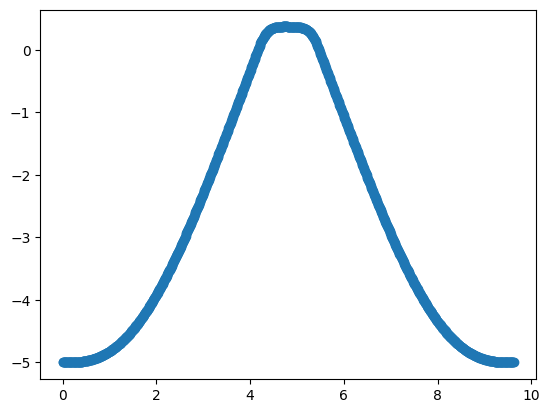

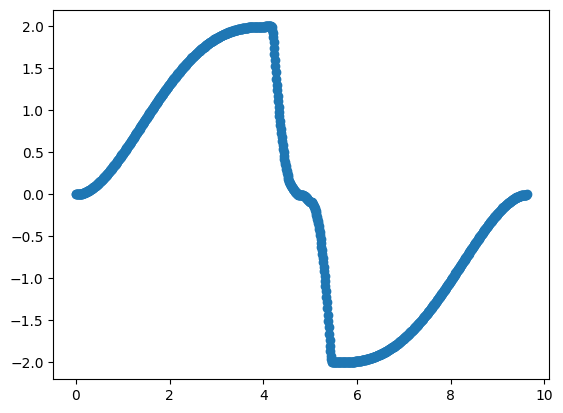

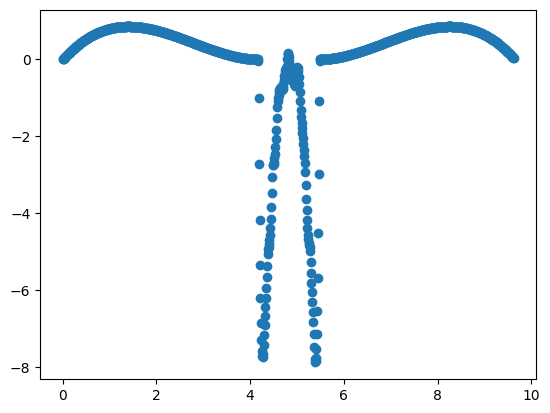

In [355]:
print(f"Execution time: {execution_time} seconds")
timeRange = np.sum(solution.x[-1*len(sfc):])
num_samples = 1000
time_vals = np.zeros(num_samples)
x_motion = np.zeros(num_samples)
v_motion = np.zeros(num_samples)
a_motion = np.zeros(num_samples)
for i in range(num_samples):
    time_vals[i] = timeRange*i/num_samples
    x_motion[i] = opt.evalPolynomial(solution.x,timeRange*i/num_samples)
    if i > 1:
        v_motion[i] =  (x_motion[i] -  x_motion[i-1])/(time_vals[i]-time_vals[i-1])
    if i > 2:
        a_motion[i] =  (v_motion[i] -  v_motion[i-1])/(time_vals[i]-time_vals[i-1])

plt.figure()
plt.scatter(time_vals,x_motion)
plt.figure()
plt.scatter(time_vals,v_motion)
plt.figure()
plt.scatter(time_vals,a_motion)
